In [29]:
# # How to load the Data

# Software setup:

# ```bash
# conda create --name tool-tracking_env python=3.12
# conda activate tool-tracking_env
# pip install -r requirements.txt
# jupyter notebook
# ```

## 0. Structure of Tool Tracking Data

You have one dedicated folder for each __(hand) tool__. On the next level are folders for each __measurement campaign__. The undermost level contains all __measurements__ of the corresponding measurement campaign.

The preferred way to access the data for analysis and learning is using the `data-tools` package which is part of this repository.

![data_structure](./info/structure_scheme.jpg)

## 1. Load Data with `data-tools`

First we have to connect to our downloaded data using the main class:

In [2]:
import os

os.chdir(r"E:\MS_AI\Sem-IV\Seminar-ADLTS\tool-tracking\data-tools")
# os.getcwd()

In [3]:

from pathlib import Path
from datatools.fixture import setup_dummy_data
# test_tool
# source = setup_dummy_data(5)

# put data into this source folder
source = "./tool-tracking-data/"
os.chdir(r"E:\MS_AI\Sem-IV\Seminar-ADLTS\tool-tracking")


In [4]:
from datatools import MeasurementDataReader, Measurement, MeasurementSeries, Action
mdr = MeasurementDataReader(source=source)

### 1.1 Create a Query to load _Measurements_ or _Actions_

Using the `mdr` object we can create a `Query` object to formulate a query to the data source.

In [5]:
q = mdr.query(query_type=Measurement)

Depending on the use case you can query for _Measurements_ which represents a temporal contiguous time series with inhomogeneous labels or _Actions_ which are parts of _Measurements_ but have the same label throughout their time range:

```python
from datatools import Action
q = mdr.query(query_type=Action)
```

### 1.2 Narrow a Query to load _Measurements_ of interest

In [115]:
from datatools import Tool, Config, MeasurementSeries, Measurement, DataTypes, Action
from datatools import ACC, GYR, MAG, MIC, POS, VEL

# mytool = "electric_screwdriver"
mytool = "pneumatic_screwdriver"
#mytool = "pneumatic_rivet_gun"
#mytool = "test_tool"

data_dict = q.filter_by(Tool == mytool, DataTypes == ACC).get()

[INFO] Preparing data from:
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s, file=data-04.annotation]

[INFO] Finished with 4 measurement(s).


In [116]:
data_dict.keys()  # we have loaded five measurements 

dict_keys(['01', '02', '03', '04'])

In [117]:
data_bunch = data_dict["01"] # data bunch for measurement with measurement id "01"
type(data_bunch)  

datatools.data.DataBunch

### 1.3 Interaction with the `DataBunch` class

A DataBunch object is a dictionary-like object that exposes its keys as attributes. Access the data with `data_bunch.acc` or `data_bunch['audio']`. You can inspect which data is contained with:

In [118]:
data_bunch.data_keys()

['acc']

In [119]:
data_bunch.acc.features

['acceleration x-axis [m/s^2]',
 'acceleration y-axis [m/s^2]',
 'acceleration z-axis [m/s^2]']

In [120]:
# matrix with raw sensor data with time column
Xt = data_bunch.acc.ts # numpy array

# matrix with raw sensor data (without time column)
X = data_bunch.acc.X  # numpy array

# target vector
y = data_bunch.acc.y  # numpy array

In [121]:
print("shape of Xt: ", Xt.shape)
print("shape of X: ", X.shape)
print("shape of y: ", y.shape)

shape of Xt:  (34271, 4)
shape of X:  (34271, 3)
shape of y:  (34271,)


### 1.4 Narrow a Query to load _Actions_ of interest

In [122]:
data_dict = mdr.query(query_type=Action).filter_by(Action == "tightening", Tool == mytool).get()

[INFO] Preparing data from:
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s, file=data-04.annotation]


[INFO] Finished with 83 action(s).


In [123]:
data_dict.keys()  # the data is now grouped by actions

dict_keys(['tightening'])

In [124]:
data_bunches = data_dict["tightening"]
print(f"{type(data_bunches)} of {type(data_bunches[0])}")

<class 'list'> of <class 'datatools.data.DataBunch'>


## 2. Create windowed Time-Series

In [125]:
os.getcwd()

'E:\\MS_AI\\Sem-IV\\Seminar-ADLTS\\tool-tracking'

In [126]:
import numpy as np
from seglearn.base import TS_Data
from seglearn.pipe import Pype
os.chdir(r"E:\MS_AI\Sem-IV\Seminar-ADLTS\tool-tracking\fhg-utils")
from fhgutils import Segment, contextual_recarray_dtype, filter_ts_data
os.chdir(r"E:\MS_AI\Sem-IV\Seminar-ADLTS\tool-tracking")
from datatools import to_ts_data

> Note: `to_ts_data` can deal with the output when querying _Measurements_ as well as _Actions_

Have a look on the seglearn [user guide](https://dmbee.github.io/seglearn/user_guide.html) to understand the data representation with `Xt` and `Xc`.

In [127]:
Xt, Xc, y = to_ts_data(data_dict, contextual_recarray_dtype)

In [128]:
window_length=0.4 # unit in s
overlap = 0.5 # unit in percent

# clean and window data
data_dict = mdr.query().filter_by(Tool == mytool).get()
Xt, Xc, y = to_ts_data(data_dict, contextual_recarray_dtype)

X = TS_Data(Xt, Xc)
pipe = Pype([
    ('segment', Segment(window_length=window_length, overlap=overlap, enforce_size=True, n=len(np.unique(Xc.desc))))
])

X_trans, y_trans = pipe.fit_transform(X, y)

[INFO] Preparing data from:
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s, file=data-04.annotation]


[INFO] Finished with 4 measurement(s).
[INFO] segment ['acc' 'gyr' 'mag' 'mic'] together
[INFO] segment ['acc' 'gyr' 'mag' 'mic'] together
[INFO] segment ['acc' 'gyr' 'mag' 'mic'] together
[INFO] segment ['acc' 'gyr' 'mag' 'mic'] together
Segment: 100%|██████████| 24868/24868 [00:01<00:00, 18888.51it/s]


### 2.1 Filter windowed Data

In [129]:
print("[INFO] extract segmented ACC data")
Xt_acc, Xc_acc, y_acc = filter_ts_data(X_trans, y_trans, filt={'desc': ['acc']})

print("[INFO] extract segmented GYR data")
Xt_gyr, Xc_gyr, y_gyr = filter_ts_data(X_trans, y_trans, filt={'desc': ['gyr']})

print("[INFO] extract segmented MAG data")
Xt_mag, Xc_mag, y_mag = filter_ts_data(X_trans,y_trans, filt={'desc': ['mag']})

print("[INFO] extract segmented MIC data")
Xt_mic, Xc_mic, y_mic = filter_ts_data(X_trans,y_trans, filt={'desc': ['mic']})

[INFO] extract segmented ACC data
[INFO] extract segmented GYR data
[INFO] extract segmented MAG data
[INFO] extract segmented MIC data


In [ ]:
Xt_acc[0].shape, Xt_gyr[0].shape, Xt_mag[0].shape, Xt_mic[0].shape, data_dict["02"]['classes']

((41, 4),
 (41, 4),
 (62, 4),
 (3200, 2),
 {38: 'impact',
  8: 'undefined',
  14: 'tightening_double',
  5: 'motor_activity_ccw',
  7: 'shaking',
  4: 'motor_activity_cw',
  3: 'untightening',
  2: 'tightening'})

In [131]:
print("[INFO] shape of ACC data is", Xt_acc.shape)
print("[INFO] shape of GYR data is", Xt_gyr.shape)
print(f"[INFO] {Xt_acc.shape[0]} windows with {Xt_acc[0].shape[1]} sample each (time stamps and 3 axis accelerometer)")

[INFO] shape of ACC data is (6217,)
[INFO] shape of GYR data is (6217,)
[INFO] 6217 windows with 4 sample each (time stamps and 3 axis accelerometer)


You can discard the time column with e.g.:
```python
Xt_acc = Xt_acc[:,:,1:]
```

### 2.2 Plot the Toy Data
> Note: In this example we deal with randomly generated toy data!

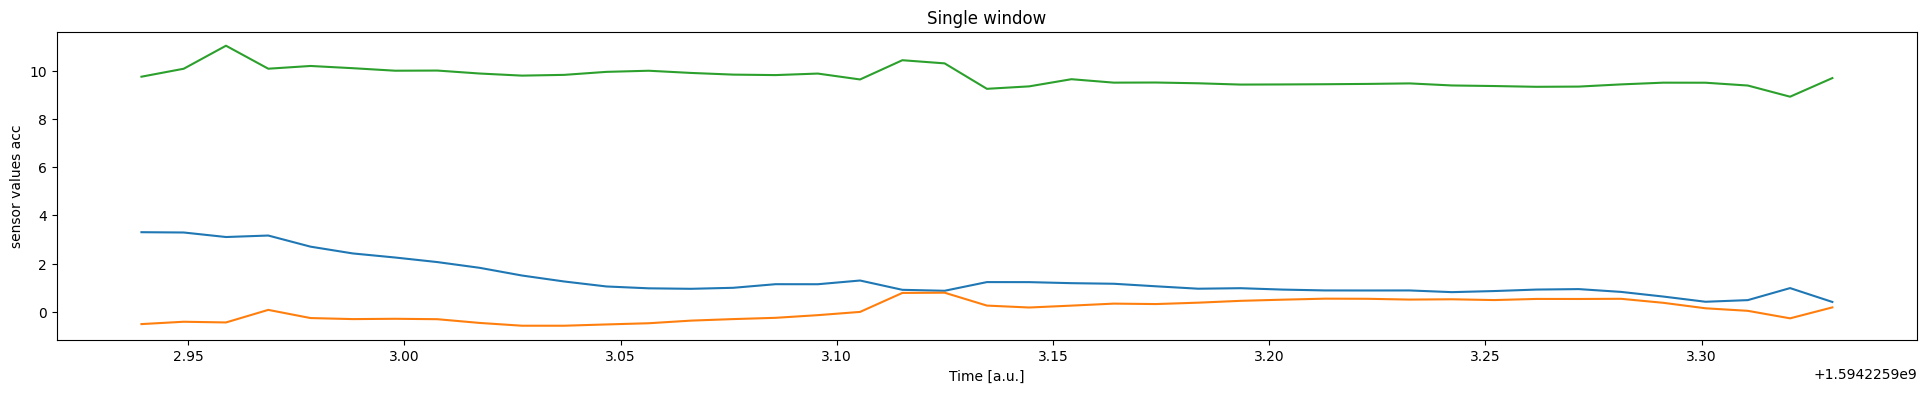

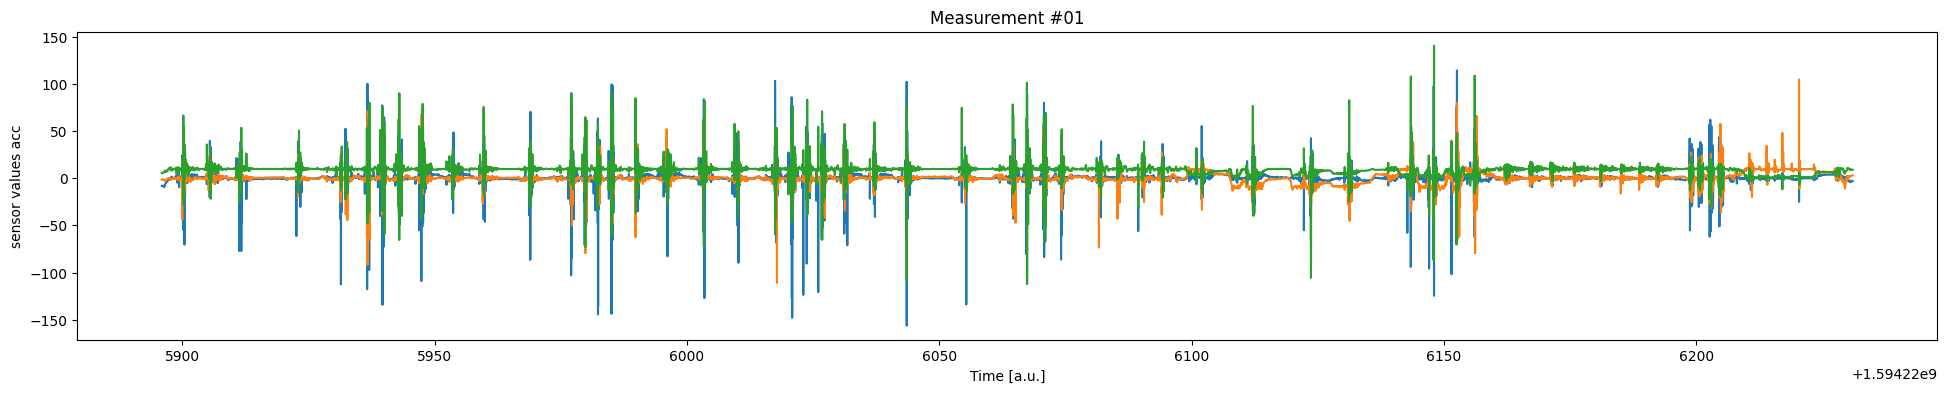

In [132]:
import matplotlib.pyplot as plt

# plot a sample
plt.figure(figsize=(24,4))
plt.title(f"Single window")
t = Xt_acc[70][:, 0]
x_win = Xt_acc[70][:, 1:]
plt.plot(t, x_win)
plt.xlabel('Time [a.u.]')
plt.ylabel('sensor values acc')
plt.show()

# plot a measurement
plotme = data_dict["01"].acc.ts
t = plotme[:, 0]
x_mea = plotme[:, 1:]
plt.figure(figsize=(24,4))
plt.title("Measurement #01")
plt.plot(t, x_mea)
plt.xlabel('Time [a.u.]')
plt.ylabel('sensor values acc')
plt.show()

## 3. Preprocess the Data

In [24]:
from fhgutils import filter_labels, one_label_per_window, summarize_labels

### 3.1 `filter_labels`
- filter out labels [-1]
- also filter out whole windows, in case there is no majority label 
- e.g. window length of 5, labels could be [1,1,1,1,0] -> okay. but if [1,1,0,0,2] -> discard window.

In [133]:
values, counts = np.unique(y_acc, return_counts=True)
for val, count in zip(values, counts):
    print(f"[INFO] label {val} with {count} samples")

[INFO] label -1.0 with 668 samples
[INFO] label 2.0 with 13339 samples
[INFO] label 3.0 with 12796 samples
[INFO] label 4.0 with 2767 samples
[INFO] label 5.0 with 2019 samples
[INFO] label 7.0 with 4135 samples
[INFO] label 8.0 with 214833 samples
[INFO] label 14.0 with 2720 samples
[INFO] label 38.0 with 1620 samples


In [137]:
y_mag[1159]

array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [138]:
Xt_acc_f, Xc_acc_f, y_acc_f = filter_labels(labels=[-1], Xt=Xt_acc, Xc=Xc_acc, y=y_acc)

[INFO] original Xt: 6217 (41, 4)
[INFO] filtered Xt: 6202 (41, 4)


### 3.2 `one_label_per_window`
- flatten labels of windows to the majority label
- `[1,1,1,1,2]` -> 1. bad if you've got `[0,0,0,0,0,1,1,1,1,1,1]` -> 1, this creates anomalous samples of class 1

In [139]:
print("pre", y_acc_f[5])
y_acc_f = one_label_per_window(y=y_acc_f)
print("post", y_acc_f[5])

pre [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
flattened 8 labels: [ 2  3  4  5  7  8 14 38]
post 8


### 3.3 `summarize_labels`
- some labels are basically very similar, like "pull_trigger, pull_trigger_air" for the Pneumatic Rivet Gun
- same action, but once holding the tool in the air, once using it on a workpiece.

In [140]:
summarylabels = {5: [0, 1]} 
y_acc_f_sum = summarize_labels(y_acc, summarylabels)

[INFO] Summarized labels from [-1.  2.  3.  4.  5.  7.  8. 14. 38.] to [-1.  2.  3.  4.  5.  7.  8. 14. 38.]



## 🔍 Advanced EDA: Correlation Analysis & Feature Importance

Before training LSTM or Transformer models, it's crucial to understand how different sensor inputs relate to each other and the target variable (if available). This helps:
- Detect redundant or highly correlated features.
- Identify leading indicators for forecasting.
- Build a strong benchmark for future comparison.

We'll start with a correlation heatmap, followed by training a baseline model to estimate feature importances.


In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is the main DataFrame with sensor data
# You may need to adapt this depending on your data structure

# Drop non-numeric or identifier columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute Pearson correlation
correlation_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Sensor Feature Correlation Matrix")
plt.tight_layout()
plt.show()



## 🎯 Baseline Model: Feature Importance Estimation

A simple Random Forest model helps evaluate the contribution of each sensor input to predicting the target variable. This step:
- Establishes a benchmark before using deep learning models.
- Highlights the most informative features.

This can be useful both for model input selection and interpretability.


In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Replace 'target_column' with the actual name of your target variable
target_column = 'target'  # e.g., 'temperature' or 'output'

# Drop rows with missing values (or use imputation if needed)
df_clean = df.dropna()

X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

# Use only numeric columns for Random Forest
X = X.select_dtypes(include=['float64', 'int64'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate performance
preds = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Baseline Random Forest RMSE: {rmse:.4f}")

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), title='Feature Importances')
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
